# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm.notebook import tqdm

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета KTH

In [0]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

for notinst in classes:
  filename = notinst + '.zip'
  if os.access(filename, os.F_OK) == False:
    print('Файл ' + filename + ' отсутствует, начинается загрузка файла')
    url = 'http://www.nada.kth.se/cvap/actions/' + filename
    !wget $url
  if os.access(notinst, os.F_OK) == False:
      print('Папка ' + notinst + ' отсутствует, начинается распаковка из архива')
      !unzip $filename -d $notinst > /dev/null

## Подготовка датасета для классификации

In [5]:
dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [6]:
SUBSET_LEN = 400
random.shuffle(dataset)
train_ds = dataset[:SUBSET_LEN]
test_ds = dataset[SUBSET_LEN:]

print('Dataset samples (subset):', len(dataset))
print('Dataset samples (train):', len(train_ds))
print('Dataset samples (test):', len(test_ds))

Dataset samples (subset): 599
Dataset samples (train): 400
Dataset samples (test): 199


## Визуализация кадра из видео

videodata shape: (620, 120, 160, 3)


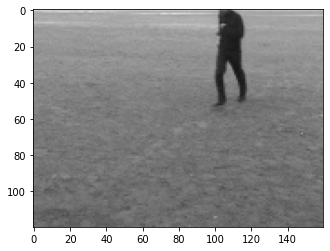

In [7]:
videodata = skvideo.io.vread(train_ds[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...]);

## Визуализация "движения"

motion shape: (619, 120, 160, 1)


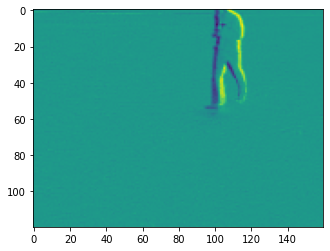

In [8]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

# Создание модели

In [0]:
NCLASSES = 6

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NCLASSES, activation=None),
])

In [0]:
inp = motion[None, ...]
out = model(inp)

# print('Input shape:', inp.shape)
# print('Output shape:', out.shape)

## Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

In [0]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [15]:
%%time
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(train_ds):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(train_ds)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/400] Loss = 1.7918533086776733
[0/10][10/400] Loss = 1.7797648906707764
[0/10][20/400] Loss = 1.7862508296966553
[0/10][30/400] Loss = 1.823920488357544
[0/10][40/400] Loss = 1.68666672706604
[0/10][50/400] Loss = 1.454660177230835
[0/10][60/400] Loss = 2.3483200073242188
[0/10][70/400] Loss = 1.9706668853759766
[0/10][80/400] Loss = 1.810597538948059
[0/10][90/400] Loss = 1.8568215370178223
[0/10][100/400] Loss = 1.575231671333313
[0/10][110/400] Loss = 1.799818992614746
[0/10][120/400] Loss = 1.039496898651123
[0/10][130/400] Loss = 1.8472392559051514
[0/10][140/400] Loss = 1.207950472831726
[0/10][150/400] Loss = 1.6545155048370361
[0/10][160/400] Loss = 1.5539828538894653
[0/10][170/400] Loss = 0.978046178817749
[0/10][180/400] Loss = 1.4878571033477783
[0/10][190/400] Loss = 1.0003254413604736
[0/10][200/400] Loss = 0.5468902587890625
[0/10][210/400] Loss = 0.5122931003570557
[0/10][220/400] Loss = 0.7983418703079224
[0/10][230/400] Loss = 0.9261751770973206
[0/10][240/40

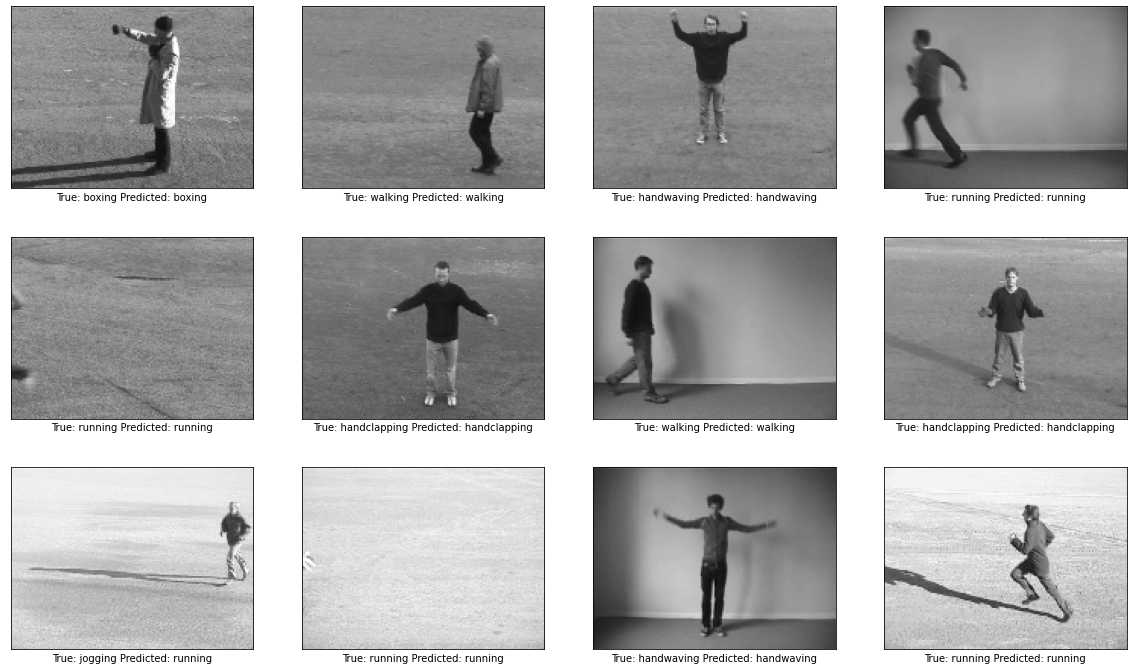

In [16]:
fig = plt.figure(figsize=(20, 12))
for j in range(12):
    fpath, cls_true = random.choice(test_ds)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    ax = fig.add_subplot(3, 4, j+1)
    ax.imshow(videodata[30, ...])
    my_string = 'True: ' + classes[cls_true] + ' Predicted: ' + classes[cls_pred]
    ax.set_xlabel(my_string)
    plt.xticks([]), plt.yticks([])
plt.show()

In [17]:
len(test_ds)

199

In [22]:
pred_true = 0
pred_true_array = []
pred_false = 0
pred_false_array = []

for j in range(len(test_ds)):
    fpath, cls_true = random.choice(test_ds)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())
    if cls_pred == cls_true:
      pred_true += 1
      pred_true_array.append(cls_true)
      pred_false_array.append(cls_pred)
    else:
      pred_false += 1
     
print('Предсказано верно: ', pred_true, ' Предсказано не верно: ', pred_false)



Предсказано верно:  170  Предсказано не верно:  29


In [0]:
model.save_weights('video_processing_KTH.h5')